# Sample Averaging for K-Arm Bandits

In [6]:
from prt_sim.jhu.bandits import KArmBandits
import prt_sim.jhu.plot as pplt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def epsilon_greedy(actions: list[int], epsilon: float) -> int:
    """
    Epsilon-greedy policy chooses the action with the highest value and samples all actions randomly with probability epsilon.

    If :math:`b > \epsilon` , use Greedy; otherwise choose randomly from amount all actions

    Args:
        actions (list[int]): list of action values
        epsilon (float): probability of choosing a random exploratory action

    Returns:
        int: Selected action
    """
    # Select action with largest value, choose randomly if there is more than 1
    a_star = np.where(actions == np.max(actions))[0]
    if len(a_star) > 1:
        a_star = np.random.choice(a_star)
    else:
        a_star = a_star[0]

    if np.random.random() > epsilon:
        action = a_star
    else:
        # Choose random from actions
        action = np.random.choice(len(actions))

    return action

class SampleAverage:
    """
    Sample Average method estimates the value of action by estimating the average sample of relevant rewards.

    """
    def __init__(self,
                 num_actions: int,
                 epsilon: float,
                 ) -> None:
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.q_values = np.zeros(self.num_actions)
        self.selections = np.zeros(self.num_actions)

    def select_action(self) -> int:
        """
        Selects the best action.

        Returns:

        """
        action = epsilon_greedy(self.q_values, self.epsilon)
        return action

    def learn(self, action: int, reward: float) -> None:
        """
        Updates the visit list and the average action value

        Args:
            action (int): Selected action that was taken
            reward (float): Reward received

        Returns:
            None
        """
        self.selections[action] += 1
        # Incremental average update
        self.q_values[action] += 1/(self.selections[action]) * (reward - self.q_values[action])

In [7]:
num_runs = 2000
num_episodes = 1000

env = KArmBandits()

actions = np.zeros((num_runs, num_episodes), dtype=int)
rewards = np.zeros((num_runs, num_episodes))
optimal_bandit = np.zeros(num_runs, dtype=int)
for run in tqdm(range(num_runs)):
    env.reset()
    optimal_bandit[run] = env.get_optimal_bandit()
    agent = SampleAverage(num_actions=env.get_number_of_actions(), epsilon=0.1)
    for step in range(num_episodes):
        action = agent.select_action()
        actions[run][step] = action
        _, reward, _ = env.execute_action(action)
        rewards[run][step] = reward
        agent.learn(action, reward)

100%|██████████| 2000/2000 [00:10<00:00, 195.70it/s]


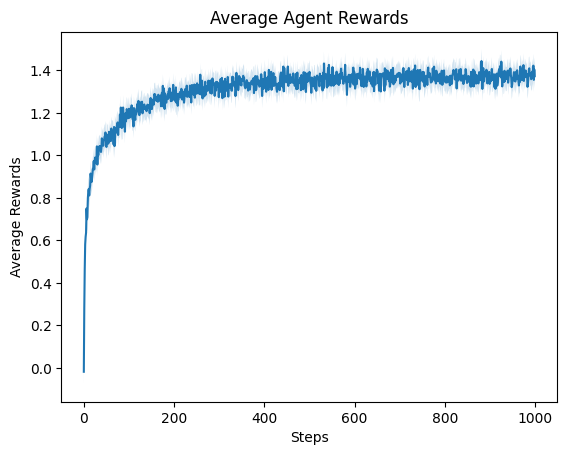

In [8]:
pplt.plot_bandit_rewards(rewards)

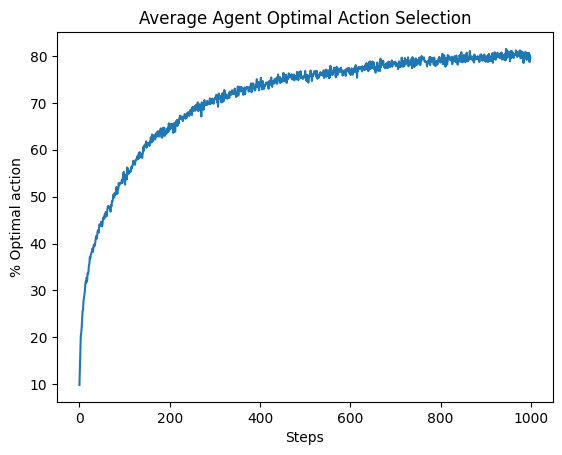

In [9]:
pplt.plot_bandit_percent_optimal_action(optimal_bandit, actions)

## PRT-RL Sample Averaging

In [2]:
from prt_rl.exact.sample_average import SampleAverage
from prt_rl.common.policies import QTablePolicy
from prt_rl.env.wrappers import JhuWrapper

In [4]:
# Set the number of runs and episodes per run
num_runs = 2000
num_episodes = 1000

# Initialize Environment
env = JhuWrapper(jhu_name="PRT-SIM/RobotGame-v0")

policy = QTablePolicy(env_params=env.get_parameters())
agent = SampleAverage(policy=policy)

agent.train(env=env, total_steps=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

AssertionError: State values must be integers.